In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import yaml
import torch
from torchvision.models import resnet18
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import random
import numpy as np
import pandas as pd
import math
from sklearn.model_selection import StratifiedKFold
from torchvision import models, transforms
from transformers import ViTForImageClassification, ViTFeatureExtractor
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from PIL import Image
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, cohen_kappa_score, confusion_matrix,
    roc_auc_score
)
from sklearn.preprocessing import label_binarize
import torchvision.transforms as transforms
from torch.cuda.amp import autocast, GradScaler

In [3]:
torch.backends.cudnn.benchmark = True

In [4]:
# Загрузка настроек
with open('/content/drive/MyDrive/Dissertation/Desertation_train_3model/дисертация_за_месяц/parametrs.yaml', 'r', encoding='utf-8') as f:
    config = yaml.safe_load(f)

# Установка сидов
seed = config['experiment']['seed']
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)


# Загружаем модель и параметры
device = torch.device(config['training']['device'] if torch.cuda.is_available() else "cpu")
num_epochs = config['training']['num_epochs']
batch_size = config['training']['batch_size']
early_stopping_patience = config['training']['patience']
learning_rate = config['training'].get('learning_rate', 1e-4)
weight_decay = config['training'].get('weight_decay', 0.01)


root_dir = '/content/drive/MyDrive/Dissertation/Desertation_train_3model/дисертация_за_месяц/train/'

In [5]:
# Путь к данным
train_csv = config['dataset']['train_csv']
val_csv = config['dataset']['val_csv']
# Загружаем CSV с метками
train_df = pd.read_csv(train_csv)
val_df = pd.read_csv(val_csv)

In [6]:
from torchvision import transforms
from PIL import Image
import os



def get_transform_pipeline(config, label=None):
    transform_list = []

    transform_config = config.get('train_transforms', {})
    common_transforms = transform_config.get('common', [])
    transform_list.extend(parse_transforms(common_transforms, config))

    # Классы 1 и 2 получают сильные аугментации
    if label in [1, 2]:
        label_key = str(label)
        class_specific = transform_config.get(label_key, [])
        transform_list.extend(parse_transforms(class_specific, config))

    transform_list.extend([
        transforms.ToTensor(),
        transforms.Normalize(mean=config['dataset']['mean'], std=config['dataset']['std'])
    ])

    return transforms.Compose(transform_list)

def parse_transforms(transform_names, config):
    transform_ops = []
    image_size = config['dataset']['image_size']
    transform_ops.append(transforms.Resize(image_size))

    for name in transform_names:
        if name == "horizontal_flip":
            transform_ops.append(transforms.RandomHorizontalFlip())
        elif name == "vertical_flip":
            transform_ops.append(transforms.RandomVerticalFlip())
        elif name == "color_jitter":
            transform_ops.append(transforms.ColorJitter(0.3, 0.3, 0.2, 0.1))
        elif name == "random_affine":
            transform_ops.append(transforms.RandomAffine(15, translate=(0.05, 0.05), scale=(0.9, 1.1), shear=5))
        elif name == "gaussian_blur":
            transform_ops.append(transforms.GaussianBlur(kernel_size=3))
        elif name == "random_erasing":
            transform_ops.append(transforms.RandomErasing(p=0.2))
        else:
            raise ValueError(f"Неизвестная трансформация: {name}")

    return transform_ops



In [7]:
# Feature Extractor для ViT
class FundusDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, root_dir, config):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.config = config

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_name = row['image_name']
        label = int(row['true_label'])
        img_path = os.path.join(self.root_dir, str(label), img_name)
        image = Image.open(img_path).convert("RGB")

        transform = get_transform_pipeline(self.config, label=label)
        image = transform(image)

        # Возвращаем изображение, метку и имя файла
        return image, label, img_name


In [8]:
def plot_training_history(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

In [9]:
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import label_binarize

def train_model(model, train_loader, val_loader, optimizer, scheduler, device, config):
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    scaler = torch.cuda.amp.GradScaler()

    early_stopping_patience = config['training'].get('early_stopping_patience', 3)
    model_save_path = config['training'].get('model_save_path', 'best_model.pth')
    num_epochs = config['training'].get('num_epochs', 20)

    best_val_loss = float('inf')
    train_losses, val_losses = [], []
    patience_counter = 0

    # Заморозим encoder (всё кроме fc)
    for param in model.parameters():
        param.requires_grad = False
    for param in model.fc.parameters():
        param.requires_grad = True

    for epoch in range(num_epochs):
        # Разморозим encoder после warmup
        if epoch == config['training'].get('freeze_encoder_epochs', 3):
            for param in model.parameters():
                param.requires_grad = True

        model.train()
        running_train_loss = 0.0

        for inputs, labels, _ in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_train_loss += loss.item()

        scheduler.step()
        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        running_val_loss = 0.0
        all_labels, all_preds = [], []
        all_probs = []
        image_names = []

        with torch.no_grad():
            for inputs, labels, filenames in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                with torch.cuda.amp.autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                running_val_loss += loss.item()

                probs = torch.softmax(outputs, dim=1)
                preds = torch.argmax(probs, dim=1)

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
                image_names.extend(filenames)

        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), model_save_path)
        elif epoch > 0 and avg_val_loss > best_val_loss and avg_train_loss < train_losses[-2]:
            patience_counter += 1
            print(f"Validation loss ↑ while train loss ↓. Patience {patience_counter}/{early_stopping_patience}")
            if patience_counter >= early_stopping_patience:
                print("Early stopping triggered due to overfitting.")
                break

    # Final metrics
    num_classes = len(set(all_labels))
    print("\nFinal Metrics on Validation Set:")
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    kappa = cohen_kappa_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Cohen's Kappa: {kappa:.4f}")
    print(f"Confusion Matrix:\n{cm}")

    try:
        y_true_bin = label_binarize(all_labels, classes=list(range(num_classes)))
        auc = roc_auc_score(y_true_bin, all_probs, multi_class='ovr', average='macro')
        print(f"AUC-ROC (OvR, macro): {auc:.4f}")
    except Exception as e:
        print(f"AUC-ROC calculation failed: {e}")

    plot_training_history(train_losses, val_losses)

    return all_labels, all_preds, all_probs, image_names


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-9-20ca9f885cb1>:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
<ipython-input-9-20ca9f885cb1>:37: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-9-20ca9f885cb1>:62: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` in

Epoch 1/30 | Train Loss: 0.7977 | Val Loss: 0.7697
Epoch 2/30 | Train Loss: 0.7492 | Val Loss: 0.7561
Epoch 3/30 | Train Loss: 0.7372 | Val Loss: 0.7453
Epoch 4/30 | Train Loss: 0.6767 | Val Loss: 0.7193
Epoch 5/30 | Train Loss: 0.5618 | Val Loss: 0.6527
Epoch 6/30 | Train Loss: 0.4164 | Val Loss: 0.7517
Validation loss ↑ while train loss ↓. Patience 1/3
Epoch 7/30 | Train Loss: 0.3311 | Val Loss: 0.7127
Validation loss ↑ while train loss ↓. Patience 2/3
Epoch 8/30 | Train Loss: 0.3065 | Val Loss: 0.6952
Validation loss ↑ while train loss ↓. Patience 3/3
Early stopping triggered due to overfitting.

Final Metrics on Validation Set:
Accuracy: 0.8015
Precision: 0.7855
Recall: 0.8015
F1 Score: 0.7845
Cohen's Kappa: 0.4329
Confusion Matrix:
[[6198  417    5]
 [1232  942   23]
 [  29   79   67]]
AUC-ROC (OvR, macro): 0.8242


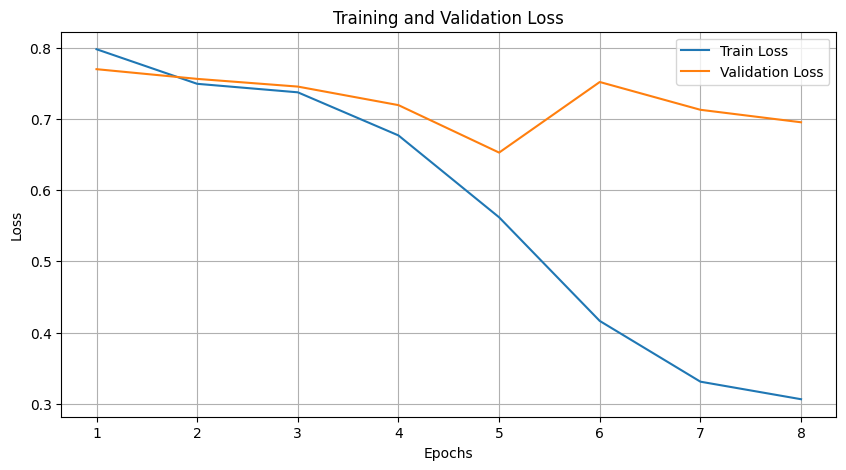

([np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64

In [11]:
train_dataset = FundusDataset(train_df, root_dir=root_dir, config=config)
val_dataset = FundusDataset(val_df, root_dir=root_dir, config=config)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=16, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=16, pin_memory=True)


# Модель
model = resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 3)  # Кол-во классов
model.to(device)

# Оптимайзер и шедулер
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

scheduler_type = config['training'].get('scheduler', 'cosine').lower()
if scheduler_type == 'cosine':
    scheduler = CosineAnnealingLR(optimizer, T_max=config['training']['num_epochs'])
elif scheduler_type == 'step':
    scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
else:
    raise ValueError(f"Unknown scheduler: {scheduler_type}")

# Тренировка
train_model(model, train_loader, val_loader, optimizer, scheduler, device, config)